In [1]:
import os, sys
from pathlib import Path

_root = next((p for p in [Path(os.getcwd()), *Path(os.getcwd()).parents]
              if p.name == 'cryptoTrading2'), None)
if _root:
    os.chdir(str(_root))
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

from files.functions import (
    base_dir,
    fullDataPath,
    dataSetup,
    trainingCols,
    _time_series_train_val_split,
    _scaler_factory,
    _tabular_future_forecast,
    _gbm_param_grid,
    _gbm_tune,
    _standardized_rmse,
    _save_model_artifact,
    _save_validation_predictions,
    _save_future_predictions,
    _save_metrics,
)
from files.CONSTANTS import COIN, RESPONSE_VARIABLE, TRAINING_COLUMNS, TEST_DAYS, LIMIT
from implementations.gbm_model import GBMModel

# GBM Training

Gradient Boosting Machine model for crypto price prediction using scikit-learn `GradientBoostingRegressor`.
This notebook walks through data loading, train/val split, hyperparameter tuning (including scaler selection),
final model training, validation evaluation, future forecasting, and artifact saving.

Dataset shape: (730, 25)
Features (23): ['open', 'high', 'low', 'volume', 'value', 'SMA_7', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'EMA_20', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'BB_STD', 'Volume_MA_7', 'OBV', 'avg_sentiment']
Target: close
Date range: 2024-02-24 00:00:00 → 2026-02-22 00:00:00


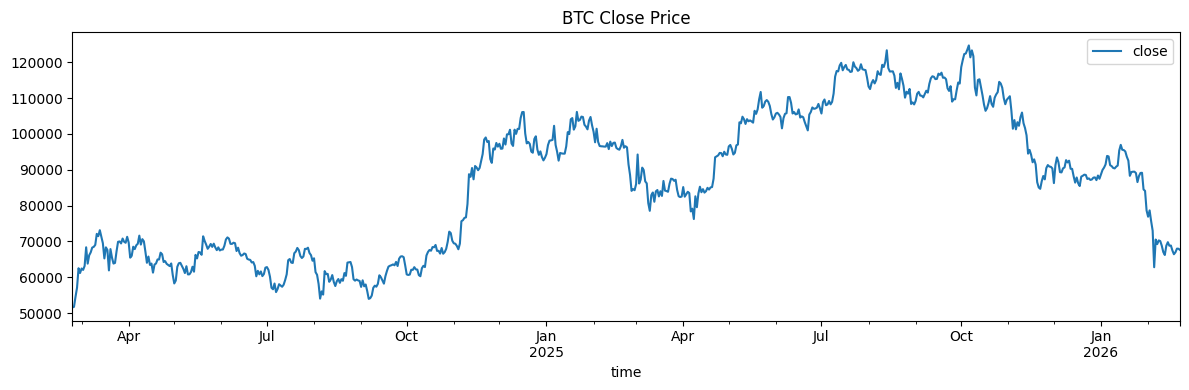


Train size: 584  |  Val size: 146


In [2]:
# ── Step 1: Load Data ────────────────────────────────────────────────────────
raw_path = fullDataPath(COIN)
data = pd.read_csv(raw_path)
daily_data = dataSetup(data, trainingColPath=TRAINING_COLUMNS, response=RESPONSE_VARIABLE, number=LIMIT)
cols = trainingCols(TRAINING_COLUMNS)
X = daily_data[cols].copy()
y = daily_data[RESPONSE_VARIABLE].copy()
print(f"Dataset shape: {daily_data.shape}")
print(f"Features ({len(cols)}): {cols}")
print(f"Target: {RESPONSE_VARIABLE}")
print(f"Date range: {daily_data.index[0]} → {daily_data.index[-1]}")
daily_data[[RESPONSE_VARIABLE]].plot(title=f"{COIN} Close Price", figsize=(12, 4))
plt.tight_layout()
plt.show()

# ── Step 2: Train / Validation Split ─────────────────────────────────────────
X_train, X_val, y_train, y_val = _time_series_train_val_split(X, y)
print(f"\nTrain size: {len(X_train)}  |  Val size: {len(X_val)}")

In [3]:
# ── Step 3: Define Hyperparameter Grid ───────────────────────────────────────
param_grid = _gbm_param_grid()
scaler_methods = ['standard', 'minmax', 'robust']

print(f"GBM param grid size: {len(param_grid)} configs")
print(f"Scaler methods to try: {scaler_methods}")
print(f"Total combinations: {len(param_grid) * len(scaler_methods)}")
print("\nSample configs:")
for cfg in param_grid[:3]:
    print(" ", cfg)

GBM param grid size: 24 configs
Scaler methods to try: ['standard', 'minmax', 'robust']
Total combinations: 72

Sample configs:
  {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
  {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
  {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [4]:
# ── Step 4: Tune Hyperparameters (includes scaler tuning) ────────────────────
print("Running GBM grid search with time-series CV...")
best_combo, tuning_results = _gbm_tune(
    X_train, y_train, param_grid, scaler_methods=scaler_methods
)

print(f"\nBest combination found:")
for k, v in best_combo.items():
    print(f"  {k}: {v}")

# Display top-5 results
tuning_df = pd.DataFrame(tuning_results).sort_values('rmse').reset_index(drop=True)
print("\nTop-5 tuning results:")
print(tuning_df.head(5).to_string(index=False))

Running GBM grid search with time-series CV...

Best combination found:
  learning_rate: 0.1
  max_depth: 5
  n_estimators: 300
  subsample: 0.8
  scaler: robust
  rmse: 7490.872730774467

Top-5 tuning results:
 learning_rate  max_depth  n_estimators  subsample   scaler        rmse
           0.1          5           300        0.8   robust 7490.872731
           0.1          5           300        0.8   minmax 7491.924077
           0.1          5           200        0.8   minmax 7492.550416
           0.1          5           200        0.8   robust 7492.568292
           0.1          5           200        0.8 standard 7493.860828


In [5]:
# ── Step 5: Train Best Model ──────────────────────────────────────────────────
# Extract scaler method and model hyperparameters from best combo
best_scaler_method = best_combo['scaler']
model_params = {k: v for k, v in best_combo.items() if k not in ('scaler', 'rmse')}

# Fit scaler on training data
scaler = _scaler_factory(best_scaler_method)
X_train_s = pd.DataFrame(
    scaler.fit_transform(X_train), index=X_train.index, columns=cols
)
X_val_s = pd.DataFrame(
    scaler.transform(X_val), index=X_val.index, columns=cols
)

# Train model
model = GBMModel(**model_params)
model.fit(X_train_s, y_train.values)
print(f"GBM model trained with params: {model_params}")
print(f"Scaler: {best_scaler_method}")

# Feature importances
importance_df = pd.DataFrame({
    'feature': cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop-10 feature importances:")
print(importance_df.head(10).to_string(index=False))

GBM model trained with params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Scaler: robust

Top-10 feature importances:
  feature  importance
     high    0.632000
      low    0.328794
    SMA_7    0.010497
     open    0.010458
 BB_Lower    0.007764
      OBV    0.005479
   EMA_12    0.002655
   BB_STD    0.000526
      RSI    0.000349
MACD_Hist    0.000330


In [6]:
# ── Step 6: Save Model to models/{COIN}/ ─────────────────────────────────────
artifact_path = _save_model_artifact(
    {'model': model, 'scaler': scaler},
    COIN,
    f'{COIN}_gbm_model.pkl'
)
print(f"Model artifact saved to: {artifact_path}")

Model artifact saved to: /Users/sucheen/Documents/cryptoTrading2/models/BTC/BTC_gbm_model.pkl


Validation RMSE:            1,300.68
Standardized RMSE (÷ std):  0.0891


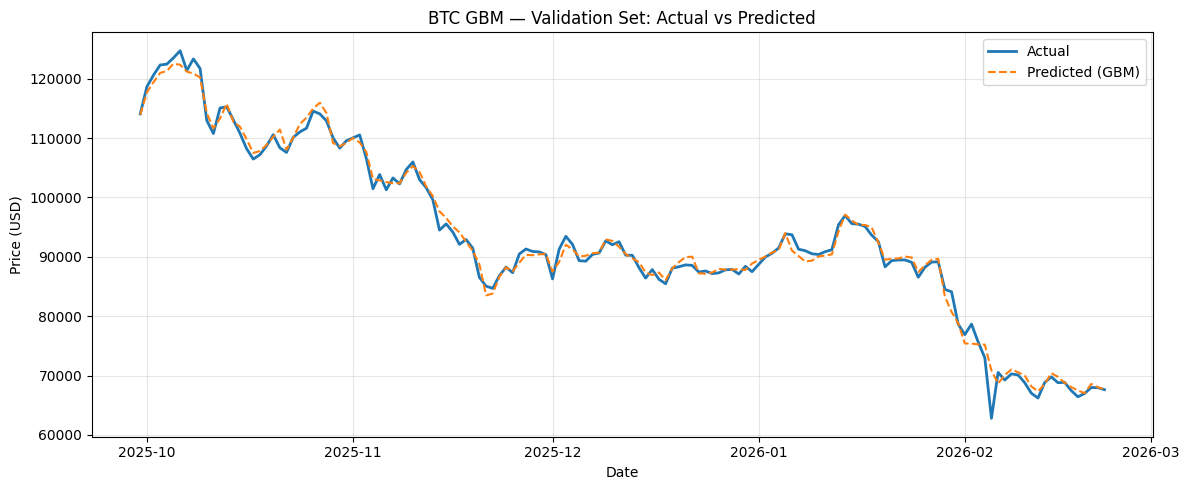

In [7]:
# ── Step 7: Predict on Validation Set ────────────────────────────────────────
val_preds = model.predict(X_val_s)
val_df = pd.DataFrame({'predicted_price': val_preds}, index=X_val_s.index)

# Compute RMSE
rmse, std_rmse = _standardized_rmse(y_val, val_preds)
print(f"Validation RMSE:            {rmse:,.2f}")
print(f"Standardized RMSE (÷ std):  {std_rmse:.4f}")

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(y_val.index, y_val.values, label='Actual', linewidth=2)
ax.plot(val_df.index, val_df['predicted_price'], label='Predicted (GBM)', linestyle='--')
ax.set_title(f"{COIN} GBM — Validation Set: Actual vs Predicted")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Future predictions for next 7 days:
            predicted_price
2026-02-23     67680.857640
2026-02-24     67458.682571
2026-02-25     67487.366189
2026-02-26     67487.366189
2026-02-27     67487.366189
2026-02-28     67487.366189
2026-03-01     67487.366189


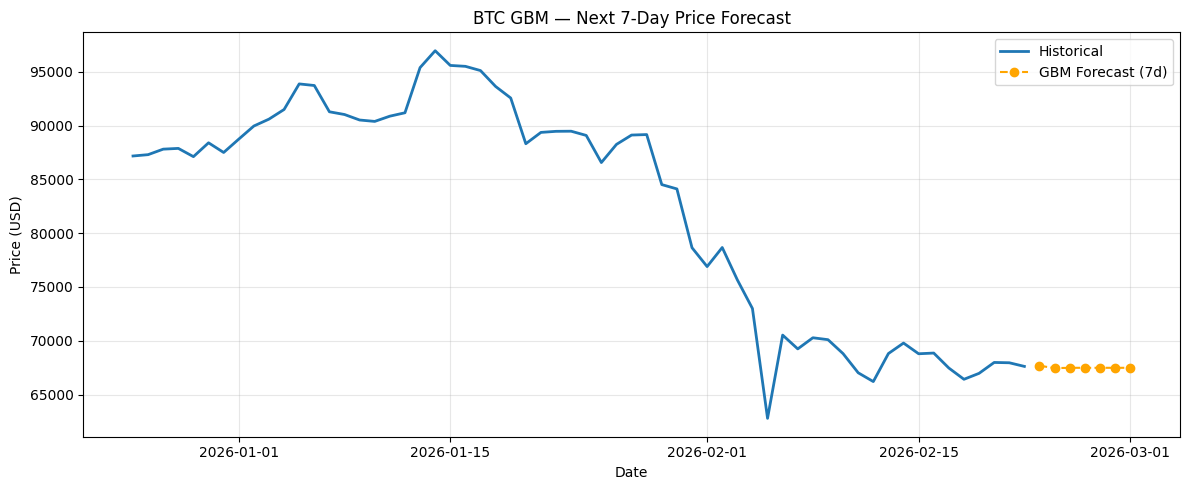

In [8]:
# ── Step 8: Predict Next TEST_DAYS Days ──────────────────────────────────────
future_df = _tabular_future_forecast(
    model, scaler, X, daily_data, cols, RESPONSE_VARIABLE, n=TEST_DAYS
)

print(f"Future predictions for next {TEST_DAYS} days:")
print(future_df.to_string())

# Plot future forecast
fig, ax = plt.subplots(figsize=(12, 5))
# Show last 60 days of historical data for context
hist = daily_data[RESPONSE_VARIABLE].iloc[-60:]
ax.plot(hist.index, hist.values, label='Historical', linewidth=2)
ax.plot(future_df.index, future_df['predicted_price'], marker='o',
        linestyle='--', label=f'GBM Forecast ({TEST_DAYS}d)', color='orange')
ax.set_title(f"{COIN} GBM — Next {TEST_DAYS}-Day Price Forecast")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
# ── Step 9: Save Predictions and Metrics ─────────────────────────────────────
val_path = _save_validation_predictions(val_df, COIN, 'gbm')
future_path = _save_future_predictions(future_df, COIN, 'gbm')
metrics_path = _save_metrics(std_rmse, COIN, 'gbm')

print(f"Validation predictions saved to: {val_path}")
print(f"Future predictions saved to:     {future_path}")
print(f"Metrics (std RMSE) saved to:     {metrics_path}")
print(f"\nStandardized RMSE: {std_rmse:.4f}")
print("Done.")

Validation predictions saved to: /Users/sucheen/Documents/cryptoTrading2/predictions/BTCgbm_validation_predictions.csv
Future predictions saved to:     /Users/sucheen/Documents/cryptoTrading2/predictions/BTCgbm_future_predictions.csv
Metrics (std RMSE) saved to:     /Users/sucheen/Documents/cryptoTrading2/metrics/BTC/gbm_rmse.txt

Standardized RMSE: 0.0891
Done.
